## Deriving the Faber-Jackson Relation Using MCMC with the Metropolis-Hastings Algorithm
The Faber-Jackson relation is an empirical relation between the luminosity of a galaxy $L$ and its velocity dispersion $v$, given by 
$$ L \propto v^4$$
as first described by [Sandra M. Faber and Robert E. Jackson in 1976](https://ui.adsabs.harvard.edu/abs/1976ApJ...204..668F?data_type=HTML&high=4481ca366126254&db_key=AST&format=) . This relation is useful because it allows us to estimate the absolute magnitude of a galaxy from its velocity dispersion, which is easier to measure; 
this can then be compared to the apparent magnitude to determine the distance to the galaxy.

In this notebook, I'll attempt to derive the Faber-Jackson relation from the data using a Markov chain Monte Carlo simulation. I'll use the Metropolis-Hastings algorithm to sample the posterior distribution of the parameters of the Faber-Jackson relation, and then we can compare the results to the empirical relation.

What follows is basically my attempt to teach myself how MCMC works, which required a lot of new concepts in statistics and probability. I've tried to explain everything as I understand it in the text below, but please forgive me if I've made any mistakes. 

I found the following resources helpful in learning about MCMC:
 - [The Wikipedia page on MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
 - [This Medium post showing a full example of how to do linear regression with MCMC in Python](https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191)
 - [This YouTube video explaining basic Bayesian statistics](https://www.youtube.com/watch?v=-1dYY43DRMA&list=PLvcbYUQ5t0UEkf2NUEo7XSsyVTyeEk3Gq)
 - [This YouTube video explaining MCMC](https://www.youtube.com/watch?v=yApmR-c_hKU)
 - [This YouTube video explaining the Metropolis-Hastings algorithm](https://www.youtube.com/watch?v=yCv2N7wGDCw&list=PLvcbYUQ5t0UEkf2NUEo7XSsyVTyeEk3Gq&index=4)

 I also found the scipy documentation about the relevant distributions (normal and gamma) very helpful. Stackexchange and stackoverflow were also helpful for debugging. I also used Github Copilot to help me autocomplete comments for the code and autocomplete some of the code itself (and this introduction) when it was able to "read my mind," so to speak. The suggestions were overall hit-or-miss, but it significantly sped up the process of writing this notebook.

 ##### The Bayesian Setup

This will essentially be the MCMC version of a linear regression. We'll expect that, for a given velocity dispersion $v$, the bolometric magnitude $M_B \ (\propto \log L)$ will be distributed according to a Gaussian distribution with mean $a + b\log v$ and standard deviation $\sigma$. (One note here: magnitude is conventionally reported with negative numbers indicating brighter objects, and I'd rather not do that, so I am actually talking about $-M_B$ when I say $M_B$.)


This means that with data $D$ and parameters $\theta = (a,b,\sigma)$, our posterior distribution is $P(\theta|D)$, our likelihood function is $P(D|\theta)$, and our prior distribution is $P(\theta)$.

From Bayes' theorem, we know that
$$ P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)} \propto P(D|\theta)P(\theta).$$

We won't need to worry about the denominator, since we're only interested in the relative probabilities of different values of $\theta$. For the purposes of this notebook, I'm also going to assume that the prior distribution is uniform, as I don't have any knowledge that would allow me to make a more informed choice. We'll also work with the log of probability distributions for numerical stability.

##### Likelihood Function
For the likelihood function, we'll assume that the data are normally distributed about the line $M_B = a + b\log v$ with standard deviation $\sigma$. I'll also assume that the data are independent, with the likelihood for one observation given by the probability density function of a normal distribution:
$$ P(D_i|\theta) = \mathrm{PDF}_{\mathcal{N}}(M_{B,i}|\theta, v_i) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(M_{B,i} - a - b\log v_i)^2}{2\sigma^2}\right).$$
The total log likelihood is then the sum of the log likelihoods for each observation:
$$ \log P(D|\theta) = \sum_i \log P(D_i|\theta) $$

##### Proposal Distribution
For the proposal distribution, we'll assume that the parameters are independent. We'll use a Gaussian distribution for $a$ and $b$. For $\sigma$, the [internet](https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191) tells me that the gamma distribution is a good choice for a positive-valued parameter, so we'll use that. So, for a current set of parameters $\theta$, we'll propose a new set of parameters $\theta'$ by drawing from the following distributions:
$$ a' \sim \mathcal{N}(a, \sigma_a)$$
$$ b' \sim \mathcal{N}(b, \sigma_b)$$
$$ \sigma' \sim \mathrm{Gamma}(\sigma \cdot \sigma_c, 1/\sigma_c)$$
where $\sigma_a$, $\sigma_b$, and $\sigma_c$ are the hyperparameters that we'll have to choose. I used $\sigma_a = \sigma_b = 0.1$ and $\sigma_c = 100$.

##### Acceptance Probability
The acceptance probability is given by
$$ A(\theta'|\theta) = \min\left(1, \frac{P(D|\theta')P(\theta')}{P(D|\theta)P(\theta)} \frac{g(\theta|\theta')}{g(\theta'|\theta)}\right)$$
where $g(\theta|\theta')$ is the probability of proposing $\theta$ given $\theta'$, and vice versa:
$$ g(a'|\theta) = \mathrm{PDF}_{\mathcal{N}}(a'|a, \sigma_a)$$
$$ g(b'|\theta) = \mathrm{PDF}_{\mathcal{N}}(b'|b, \sigma_b)$$
$$ g(\sigma'|\theta) = \mathrm{PDF}_{\mathrm{Gamma}}(\sigma'|\sigma \cdot \sigma_c, 1/\sigma_c)$$

For the Metropolis-Hastings algorithm, if $A(\theta'|\theta) > 1$, we accept the new parameters. If $A(\theta'|\theta) < 1$, we accept the new parameters with probability $A(\theta'|\theta)$, which we will evaluate by drawing a random number $r$ from a uniform distribution between 0 and 1 and accepting the new parameters if $r < A(\theta'|\theta)$.

##### Algorithm in Brief
1. Initialize parameters $\theta$ (randomly chosen)
2. Propose new parameters $\theta'$ from proposal distribution
3. Calculate acceptance probability $A(\theta'|\theta)$
4. Accept new parameters with probability $A(\theta'|\theta)$, or always accept if $A(\theta'|\theta) > 1$. If accepted, set $\theta = \theta'$.
5. Repeat steps 2-4 until desired number of samples is reached.

This algorithm will produce a set of samples from the posterior distribution of the parameters $\theta$. We'll only determine the posterior distributions samples after the chain has converged, throwing out samples from the beginning of the chain.

Our main parameter of interest is $b$, which gives the power law index of the Faber-Jackson relation. Hopefully, we'll find that $b \approx 4$.

# The Code

Text(0.5, 1.0, 'Luminosity vs. Velocity Dispersion (Faber & Jackson 1976)')

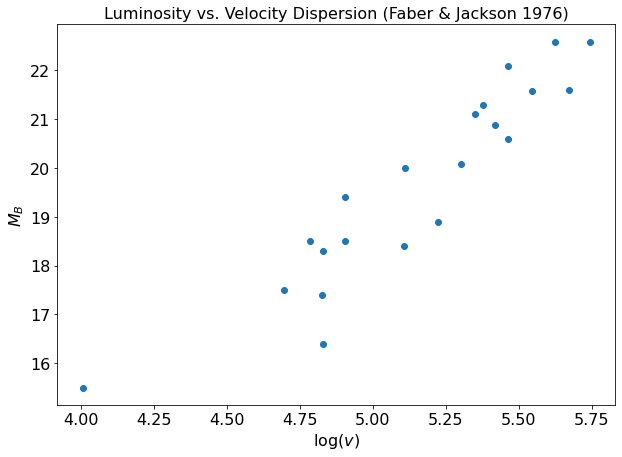

In [11]:
# First, we'll import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Next, we'll import the data from Faber and Jackson (1976). I got this data from the paper itself, using the data from Figure 16 extracted using WebPlotDigitizer.
data = np.genfromtxt('/Users/ssiegel/Library/CloudStorage/Box-Box/2023/phys290/Finalproject/FaberJacksonwpd.csv', delimiter=',')

# Changing it so brighter galaxies have higher magnitudes instead of lower
data[:,0] = -data[:,0]

# Let's take a look at the data
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 7))
plt.scatter(np.log(data[:,1]), data[:,0])
plt.xlabel('$\\log(v)$', fontsize=16)
plt.ylabel('$M_B$', fontsize=16)
plt.title('Luminosity vs. Velocity Dispersion (Faber & Jackson 1976)', fontsize=16)

In [12]:
# Now, we'll define the functions we'll need to propose new thetas, calculate the likelihood, and calculate the acceptance probability

def proposal(previous_theta, width=[0.2, 0.2, 100]):
    '''Draw a new theta from the distribution g(theta_new|theta_previous).
    We'll draw from a normal distribution for a and b, and a gamma distribution for sigma_err.
    '''
    new_theta = np.zeros(len(previous_theta))
    new_theta[0] = np.random.normal(previous_theta[0], width[0])
    new_theta[1] = np.random.normal(previous_theta[1], width[1])
    new_theta[2] = st.gamma.rvs(previous_theta[2]*width[2], scale=1./width[2])
    return new_theta

def log_likelihood(theta, data):
    '''Compute the log likelihood of the data given the parameters theta.
    We'll use the probability density function of the normal distribution.'''
    a = theta[0]
    b = theta[1]
    sigma_err = theta[2]
    log_likelihood = st.norm.logpdf(data[:,0], loc=a + b * np.log(data[:,1]), scale=sigma_err)
    return np.sum(log_likelihood)

def log_prior(theta):
    '''Compute the log prior of the parameters theta.
    We'll assume uniform priors for a and b, and a gamma distribution for sigma_err.
    Right now, I'm assuming uniform priors, so this function is just mainly placeholder in case I'd want a more complicated function.'''
    a = theta[0]
    b = theta[1]
    sigma_err = theta[2]
    #log_prior = 0*st.norm.logpdf(a, loc=0) + 0*st.norm.logpdf(b, loc=0) + 0*st.gamma.logpdf(sigma_err, a=1, scale=1)
    log_prior = 0
    return log_prior

def compute_bayes_factor(theta_new, theta_previous, data):
    '''Compute the Bayes factor for the data given the parameters theta.
    We'll use the log likelihood and log prior functions defined above.'''
    log_bayes_factor_new = log_likelihood(theta_new, data) + log_prior(theta_new)
    log_bayes_factor_previous = log_likelihood(theta_previous, data) + log_prior(theta_previous)
    log_bayes_factor = log_bayes_factor_new - log_bayes_factor_previous
    return log_bayes_factor

def proposal_ratio(theta_new, theta_previous, width = [0.2, 0.2, 100]):
    '''Compute the ratio of the proposal distributions g(theta_new|theta_previous) and g(theta_previous|theta_new).'''
    log_prop_oldtonew = st.norm.logpdf(theta_new[0], loc=theta_previous[0], scale=width[0]) + st.norm.logpdf(theta_new[1], loc=theta_previous[1], scale=width[1]) + st.gamma.logpdf(theta_new[2], a=theta_previous[2]*width[2], scale=1./width[2])
    log_prop_newtoold = st.norm.logpdf(theta_previous[0], loc=theta_new[0], scale=width[0]) + st.norm.logpdf(theta_previous[1], loc=theta_new[1], scale=width[1]) + st.gamma.logpdf(theta_previous[2], a=theta_new[2]*width[2], scale=1./width[2])
    return log_prop_newtoold - log_prop_oldtonew

In [36]:
# Now, we'll define the MCMC function and run it
def metropolis_hastings(data, n_iterations=100000, width=[0.1, 0.1, 100]):
    '''Run the Metropolis-Hastings algorithm to estimate the parameters theta.
    We'll use the proposal, log likelihood, log prior, bayes factor, and proposal ratio functions defined above.'''
    thetas = np.zeros((n_iterations, 3))
    acceptances = np.zeros(n_iterations)
    proposals = np.zeros((n_iterations, 3))
    # Initialize theta
    theta = np.random.uniform(-1, 1, size=3)
    theta[2] = np.random.gamma(1, scale=1)
    #theta[1] = 4
    for i in range(n_iterations):
        if i%10000 == 0:
            print(i)
        # Propose a new theta
        theta_new = proposal(theta, width=width)
        proposals[i] = theta_new
        # Compute the Bayes factor
        log_bayes_factor = compute_bayes_factor(theta_new, theta, data)
        # Compute the proposal ratio
        log_prop_ratio = proposal_ratio(theta_new, theta, width=width)
        # Compute the acceptance ratio
        log_acceptance_ratio = log_bayes_factor + log_prop_ratio
        acceptances[i] = np.exp(log_acceptance_ratio)
        # Accept or reject the new theta
        if (np.random.uniform(0, 1)) < np.exp(log_acceptance_ratio):
            theta = theta_new
        thetas[i,:] = theta
    return thetas, acceptances, proposals

# 5000000 iterations took me about 6ish minutes to run on my computer. It will converge very fast, but the parameters will still be wandering around a fair amount. 
# So half a million iterations gives it plenty of time to wander, allowing us to better sample the posterior distribution.
thetas, acceptances, proposals = metropolis_hastings(data, n_iterations=500000, width=[.1, .1, 100])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


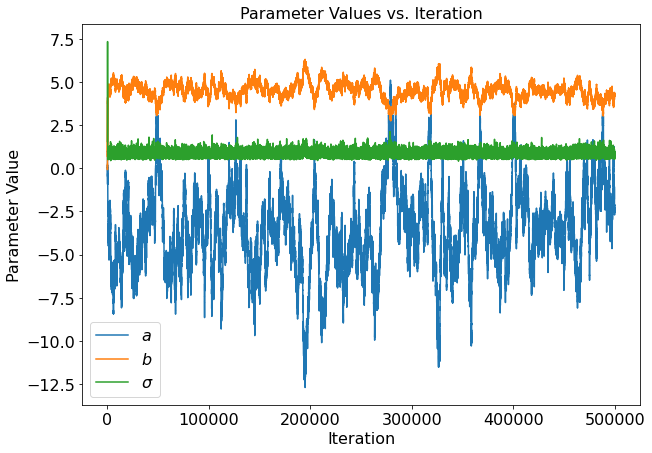

In [37]:
# Now, we'll plot the results
# First, we'll plot the values of theta as a function of iteration

plt.figure(figsize=(10, 7))
plt.plot(thetas[:,0], label='$a$')
plt.plot(thetas[:,1], label='$b$')
plt.plot(thetas[:,2], label='$\sigma$')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Parameter Value', fontsize=16)
plt.title('Parameter Values vs. Iteration', fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.show()

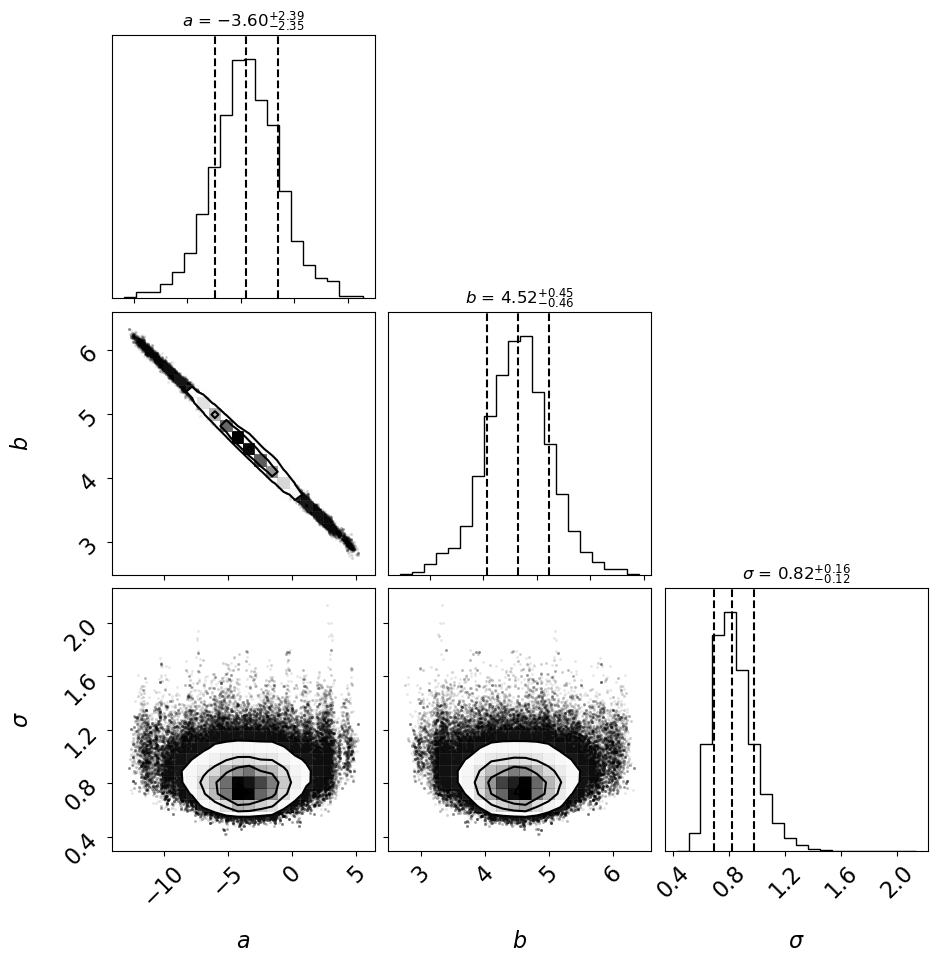

In [69]:
# We'll throw out the first 100000 iterations as burn-in
thetas2 = thetas[100000:,:]
a = thetas2[:,0]
b = thetas2[:,1]
sigma = thetas2[:,2]

# Now, time to actually plot the the results
# I'm using the handy corner python package to easily view the distributions of the parameters
import corner
fig = plt.figure(figsize=(10, 10), dpi=100)
corner_plot=corner.corner(thetas2, labels=['$a$', '$b$', '$\sigma$'], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, fig=fig)

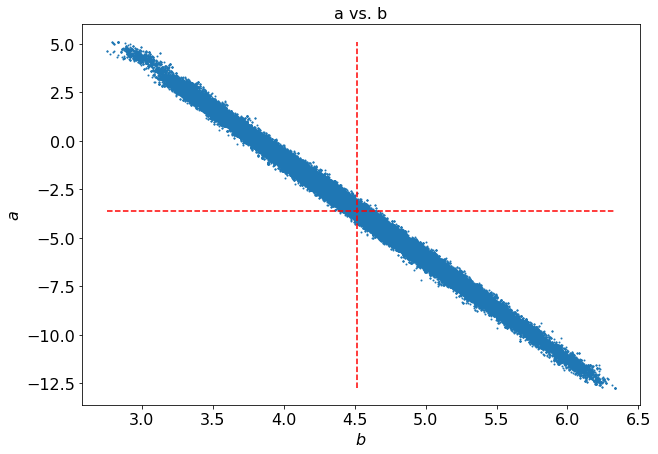

In [57]:
# It looks like the median value for b is 4.5(5). As we can see from the corner plot, there is a clear correlation between a and b. 
# So, we'll have to find the best fit value for a based on the best fit value for b.
# I'll do this by plotting a vs. b and identifying the approximate value of a at b=4.5

plt.figure(figsize=(10, 7))
plt.scatter(b, a, s=1)
plt.xlabel('$b$', fontsize=16)
plt.ylabel('$a$', fontsize=16)
plt.title('a vs. b', fontsize=16)
plt.vlines(np.mean(b), np.min(a), np.max(a), color='r', linestyle='--')
plt.hlines(-3.6, np.min(b), np.max(b), color='r', linestyle='--')
plt.show()

# A strong correlation, indeed.
# As it turns out, the it looks like the median value of a of 3.6 +- 2 is pretty good for b=4.5

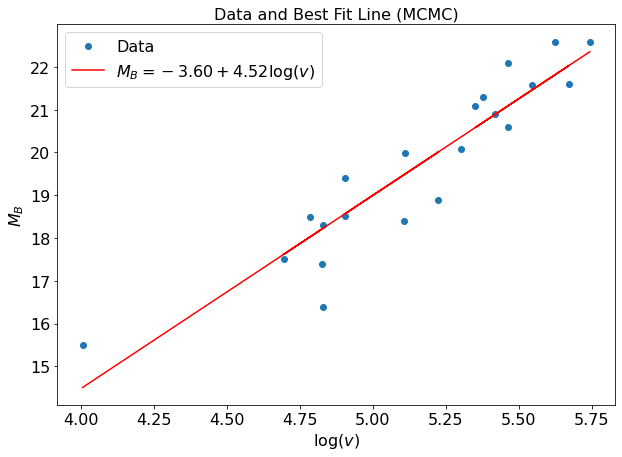

In [58]:
# Now, we'll plot the data and the best fit line
a_best = np.median(a)
b_best = np.median(b)
plt.figure(figsize=(10, 7))
plt.scatter(np.log(data[:,1]), data[:,0], label='Data')
plt.plot(np.log(data[:,1]), a_best + b_best * np.log(data[:,1]), color='red', label='$M_B = %.2f + %.2f \log(v)$' % (a_best, b_best))
plt.xlabel('$\\log(v)$', fontsize=16)
plt.ylabel('$M_B$', fontsize=16)
plt.title('Data and Best Fit Line (MCMC)', fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.show()

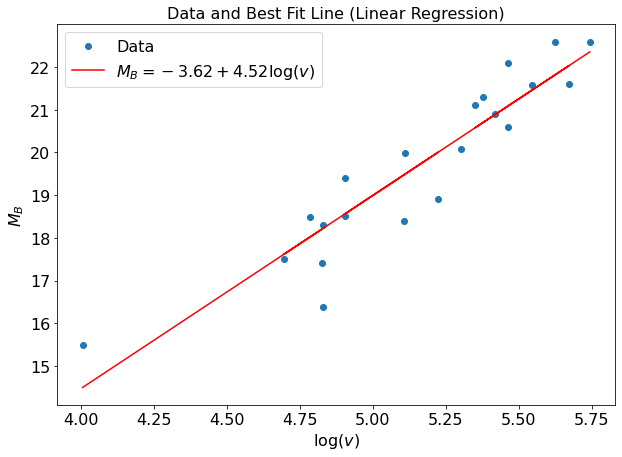

In [59]:
# For comparison, we'll also plot the data and the best fit line from a standard linear regression
plt.figure(figsize=(10, 7))
plt.scatter(np.log(data[:,1]), data[:,0], label='Data')
c = st.linregress(np.log(data[:,1]), data[:,0])
plt.plot(np.log(data[:,1]), c[1] + c[0] * np.log(data[:,1]), color='red', label='$M_B = %.2f + %.2f \log(v)$' % (c[1], c[0]))
plt.xlabel('$\\log(v)$', fontsize=16)
plt.ylabel('$M_B$', fontsize=16)
plt.title('Data and Best Fit Line (Linear Regression)', fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.show()

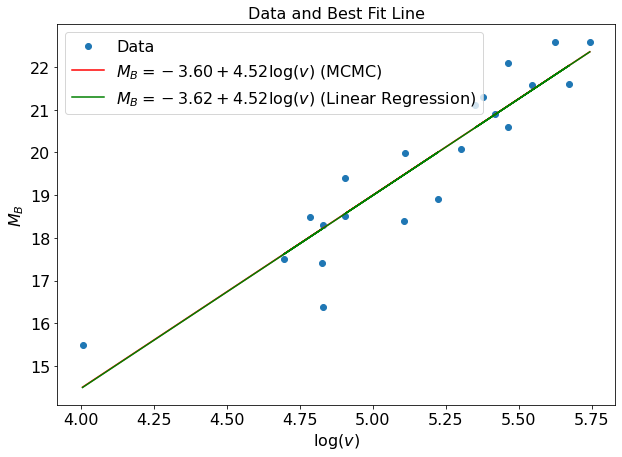

In [60]:
# We'll plot both the MCMC and linear regression results on the same plot to compare them
plt.figure(figsize=(10, 7))
plt.scatter(np.log(data[:,1]), data[:,0], label='Data')
plt.plot(np.log(data[:,1]), a_best + b_best * np.log(data[:,1]), color='red', label='$M_B = %.2f + %.2f \log(v)$ (MCMC)' % (a_best, b_best))
plt.plot(np.log(data[:,1]), c[1] + c[0] * np.log(data[:,1]), color='green', label='$M_B = %.2f + %.2f \log(v)$ (Linear Regression)' % (c[1], c[0]))
plt.xlabel('$\\log(v)$', fontsize=16)
plt.ylabel('$M_B$', fontsize=16)
plt.title('Data and Best Fit Line', fontsize=16)
plt.legend(fontsize=16, loc='best')
plt.show()

# They're very close, especially given the relatively high undertainty.

#### Closing Remarks

We set out to derive the Faber-Jackson relation using MCMC with the Metropolis-Hastings algorithm. The power law index we found was $b = 4.5(5)$, which is not *too* far off of the expected power law index of 4. The uncertainty is quite large, however, which makes sense given the small number of data points and the fact that the Faber-Jackson relation is an empirical relation that is not expected to hold exactly. Even the standard linear regression method gave a power law index of $b = 4.5$, which is essentially the same as the MCMC result.

Even once the chain converged, we still notice a lot of wandering in the parameter values. It's not totally surprising given that there is a fair amount of scatter in the data. It is also not surprising to find that $a$ and $b$ are strongly correlated, since they are both parameters of the same line. 

I think the results are certainly better than I was expecting considering how new I am to MCMC. But I would love to keep exploring and try to get more comfortable.



*I affirm that I have upheld the Honor Code in this assignment.*  
**Sammy Siegel**, 10 May 2023